# ANN鸢尾花分类自定义等级量化

代码说明：使用ANN网络进行鸢尾花数据集分类并进行自定义等级量化

作者：复旦大学 微电子学院 赵振宇

In [13]:
# 引入库
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchsummary import summary # 用于预览神经网络结构的库
import time
import csv

In [14]:
# 配置基本信息
# 配置运行硬件平台
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# 指定数据集地址
dataset_dir = "./dataset" # 数据集地址
# 指定数据集的batch_size
batch_size = 30
# 设定自动保存模型的地址
model_auto_save_dir = "./model_save/auto_save/"
# 设定手动保存模型的地址
model_history_save_dir = "./model_save/history_save/"
# 设定外部图片地址
# 请务必确保对应文件夹中有该图片
img_path = "./dataset/images1.jpg"
# jupyter输出不打印省略号
torch.set_printoptions(threshold=np.inf)

device: cuda:0


In [26]:
# 将鸢尾花数据集转换为DataLoader
# 自定义 Dataset 类
class IrisDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.features = []
        self.labels = []
        self.transform = transform
        
        # 读取 CSV 文件
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # 跳过表头
            for row in reader:
                # 前四列为特征，最后一列为标签
                feature = list(map(float, row[:-1]))
                label = row[-1]
                # 将标签转换为数值
                if label == 'setosa':
                    label = 0
                elif label == 'versicolor':
                    label = 1
                elif label == 'virginica':
                    label = 2
                else:
                    raise ValueError(f"未知的标签: {label}")
                self.features.append(feature)
                self.labels.append(label)
        
        # 转换为张量
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.tensor(self.labels, dtype=torch.int64)

        # 将特征值归一化
        self.features = F.normalize(self.features, p=float('inf'), dim=1)
    
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # 返回特征和标签
        return self.features[idx], self.labels[idx]


# 设置文件路径
train_csv_path = "./dataset/iris_train.csv" # 替换为你的训练集 CSV 文件路径
test_csv_path = "./dataset/iris_test.csv"    # 替换为你的测试集 CSV 文件路径

# 创建 Dataset
train_dataset = IrisDataset(train_csv_path)
test_dataset = IrisDataset(test_csv_path)

# 打印训练数据集长度
train_dataset_size = len(train_dataset)
print(train_dataset_size)
# 打印测试数据集长度
test_dataset_size = len(test_dataset)
print(test_dataset_size)

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

120
30


In [27]:
# DataLoader测试
for data in test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    print(f"inputs = {inputs}")
    # print(f"labels = {labels}")

inputs = tensor([[1.0000, 0.7000, 0.2600, 0.0600],
        [1.0000, 0.5111, 0.2889, 0.0667],
        [1.0000, 0.7273, 0.2955, 0.0455],
        [1.0000, 0.7000, 0.3200, 0.1200],
        [1.0000, 0.7451, 0.3725, 0.0784],
        [1.0000, 0.6250, 0.2917, 0.0625],
        [1.0000, 0.7451, 0.3137, 0.0392],
        [1.0000, 0.6957, 0.3043, 0.0435],
        [1.0000, 0.6981, 0.2830, 0.0377],
        [1.0000, 0.6600, 0.2800, 0.0400],
        [1.0000, 0.4727, 0.8000, 0.2182],
        [1.0000, 0.4918, 0.7541, 0.2295],
        [1.0000, 0.4483, 0.6897, 0.2069],
        [1.0000, 0.4600, 0.6600, 0.2000],
        [1.0000, 0.4821, 0.7500, 0.2321],
        [1.0000, 0.5263, 0.7368, 0.2105],
        [1.0000, 0.5088, 0.7368, 0.2281],
        [1.0000, 0.4677, 0.6935, 0.2097],
        [1.0000, 0.4902, 0.5882, 0.2157],
        [1.0000, 0.4912, 0.7193, 0.2281],
        [1.0000, 0.4627, 0.8358, 0.3582],
        [1.0000, 0.4493, 0.7391, 0.3333],
        [1.0000, 0.4655, 0.8793, 0.3276],
        [1.0000, 0.4706, 

In [28]:
# 定义网络架构
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = nn.Linear(n_input, n_hidden, bias=False)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_hidden, n_output, bias=False)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x
    
# 实例化神经网络
net = Net(n_input=4, n_hidden=4, n_output=3)
net = net.to(device) # 将神经网络转换
# 加载之前训练过的网络
# net = torch.load("net_CIFAR10.pth")

# 打印神经网络信息
print("神经网络信息")
print(net)

# 测试神经网络的输出格式
# 设置满足要求的输入
input = torch.ones([4])
input = input.to(device)
print("输入数据格式", input.shape)

output = net(input)
print("输出数据格式", output.shape)

# 查看神经网络模型大小
summary(net, input_size=[[1, 4]])

神经网络信息
Net(
  (hidden): Linear(in_features=4, out_features=4, bias=False)
  (relu): ReLU()
  (output): Linear(in_features=4, out_features=3, bias=False)
)
输入数据格式 torch.Size([4])
输出数据格式 torch.Size([3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              16
              ReLU-2                 [-1, 1, 4]               0
            Linear-3                 [-1, 1, 3]              12
Total params: 28
Trainable params: 28
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [29]:
# 设置神经网络超参数
# 设置损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device) # 将损失函数转换

# 设置优化器
learning_rate = 0.01 # 设置学习率
lambda_val = 0.0 # 设置正则化系数Lambda
optim = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=lambda_val)

In [30]:
# 设定训练轮数
epoch = 500
epoch_show = 50 # 每epoch_show次展示输出结果
# 定义训练集loss以及准确率变量
loss_train = 0.0 # 训练损失值
loss_train_sum = 0.0 # 训练损失值累加值
loss_train_mean = 0.0 # 这一轮训练损失值的平均值
loss_train_store = np.zeros(epoch) # 训练损失值存储数组
accuracy_train = 0 # 训练准确数
accuracy_rate_train = 0.0 # 训练准确率
accuracy_rate_train_max = 0.0 # 最大训练准确率
accuracy_rate_train_store = np.zeros(epoch) # 训练准确率存储素数组
# 定义交叉验证集loss以及准确率变量
loss_cv = 0.0 # 验证损失值
loss_cv_sum = 0.0 # 验证损失值累加值
loss_cv_mean = 0.0 # 这一轮验证损失值的平均值
loss_cv_store = np.zeros(epoch) # 验证损失值存储数组
accuracy_cv = 0 # 验证准确数
accuracy_rate_cv = 0.0 # 验证准确率
accuracy_rate_cv_max = 0.0 # 最大验证准确率
accuracy_rate_cv_store = np.zeros(epoch) # 验证准确率存储素数组

In [31]:
# 训练网络

#########################开始训练########################
for i in range(epoch):
    if(i % epoch_show == 0): # 每epoch_show次输出
        print("-----------第%d轮训练开始------------" %i)
    # 每轮loss累加值清零
    loss_train_sum = 0
    loss_cv_sum = 0
    # 开始训练神经网络
    net.train()
    # 这一轮的训练计数
    train_step = 0
    # 准确性变量清零
    accuracy_train = 0
    
    for data in train_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

		# 输入神经网络并运行
        output = net(inputs)

		# 计算损失函数
        loss_train = loss_fn(output, labels)
        # 累加损失函数
        loss_train_sum += loss_train.item()
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 累加计算结果准确性
        accuracy_train += (pred_label == labels).sum()
        # 清零优化器的累计梯度
        optim.zero_grad()
        # 计算梯度
        loss_train.backward()
        # 优化器开始优化
        optim.step()
    
    # 计算训练集损失函数loss train
    loss_train_mean = loss_train_sum / (train_dataset_size/batch_size)
    loss_train_store[i] = loss_train_mean
    # 计算训练集准确率
    accuracy_rate_train = (accuracy_train/train_dataset_size) * 100
    accuracy_rate_train_store[i] = accuracy_rate_train
    
    
    # 开始测试神经网络
    net.eval()
    # 总测试次数
    test_step = 0
    # 准确性变量清零
    accuracy_cv = 0
    with torch.no_grad(): # 预测阶段不进行梯度下降
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 输入神经网络并运行
            output = net(inputs)
            # 计算损失函数
            loss_cv = loss_fn(output, labels)
            # 累加损失函数
            loss_cv_sum += loss_cv.item()
            # 将分类概率转化为对应标签
            pred_label = output.argmax(1)
            # 累加计算结果准确性
            accuracy_cv += (pred_label == labels).sum()
            test_step += 1

    # 计算交叉验证集损失函数loss cv
    loss_cv_mean = loss_cv_sum / (test_dataset_size/batch_size)
    loss_cv_store[i] = loss_cv_mean
    # 计算交叉验证集准确率
    accuracy_rate_cv = (accuracy_cv/test_dataset_size) * 100
    accuracy_rate_cv_store[i] = accuracy_rate_cv

    # 输出该轮训练结果
    if(i % epoch_show == 0): # 每50次输出
        print("loss train: %.5f, accuracy rate train: %.5f%%, loss cv: %.5f, accuracy rate cv: %.5f%%" %(loss_train_mean, accuracy_rate_train.item(), loss_cv_mean, accuracy_rate_cv.item()))
    # 自动保存训练过程中准确率大于之前的神经网络模型
    if (accuracy_rate_train + accuracy_rate_cv > accuracy_rate_train_max + accuracy_rate_cv_max):
        torch.save(net, model_auto_save_dir + "model_auto_save_acc%d.pth" %accuracy_rate_cv)
        accuracy_rate_train_max = accuracy_rate_train # 记录最大训练准确率
        accuracy_rate_cv_max = accuracy_rate_cv # 记录最大训练准确率

#########################结束训练########################
print("-------------------------------训练完成-------------------------------")

-----------第0轮训练开始------------
loss train: 1.16117, accuracy rate train: 32.50000%, loss cv: 1.14671, accuracy rate cv: 33.33334%
-----------第50轮训练开始------------
loss train: 0.41139, accuracy rate train: 93.33334%, loss cv: 0.39817, accuracy rate cv: 96.66667%
-----------第100轮训练开始------------
loss train: 0.21239, accuracy rate train: 95.83334%, loss cv: 0.16516, accuracy rate cv: 100.00000%
-----------第150轮训练开始------------
loss train: 0.14731, accuracy rate train: 95.83334%, loss cv: 0.08464, accuracy rate cv: 100.00000%
-----------第200轮训练开始------------
loss train: 0.12303, accuracy rate train: 95.83334%, loss cv: 0.05208, accuracy rate cv: 100.00000%
-----------第250轮训练开始------------
loss train: 0.11089, accuracy rate train: 95.83334%, loss cv: 0.03730, accuracy rate cv: 100.00000%
-----------第300轮训练开始------------
loss train: 0.10449, accuracy rate train: 95.00001%, loss cv: 0.02919, accuracy rate cv: 100.00000%
-----------第350轮训练开始------------
loss train: 0.09955, accuracy rate train:

---------损失函数Loss随训练轮数epoch的变化图像---------


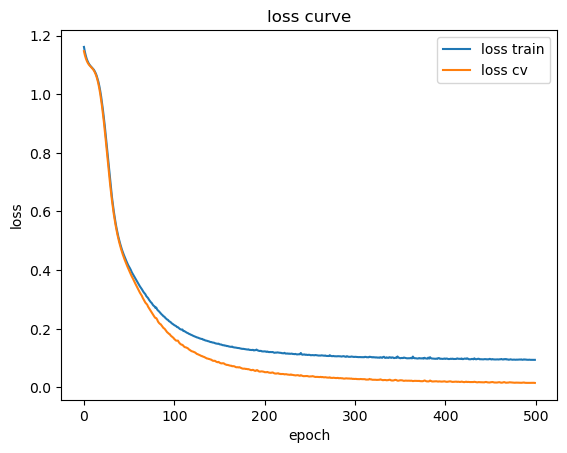

---------准确率accuracy随训练轮数epoch的变化图像---------


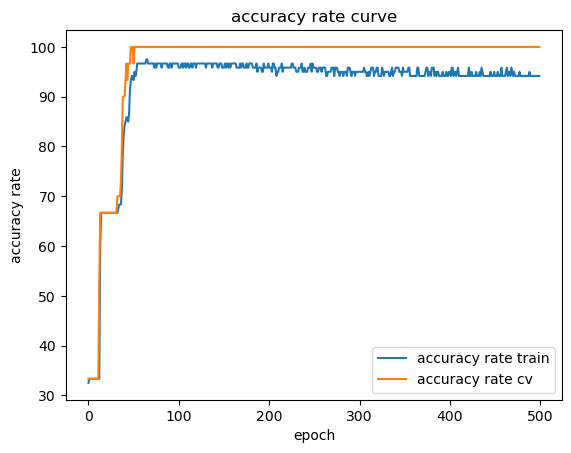

In [32]:
# 画出loss曲线
print("---------损失函数Loss随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), loss_train_store, np.arange(epoch), loss_cv_store)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss train", "loss cv"])
plt.title("loss curve")
plt.show()

# 画出accuracy曲线
print("---------准确率accuracy随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), accuracy_rate_train_store, np.arange(epoch), accuracy_rate_cv_store)
plt.xlabel("epoch")
plt.ylabel("accuracy rate")
plt.legend(["accuracy rate train", "accuracy rate cv"])
plt.title("accuracy rate curve")
plt.show()

In [33]:
# 自定义等级量化函数
def quantize_weights(model, int_min=-7, int_max=7):
    """
    将模型权重量化为指定整数范围
    Args:
        model: PyTorch模型
        int_min: 最小整数值 (默认-7)
        int_max: 最大整数值 (默认7)
    Returns:
        量化后的模型
    """

    with torch.no_grad():
        for name, param in model.named_parameters():
            # 计算权重的绝对最大值
            max_abs = torch.max(torch.abs(param.data))
            
            # 计算缩放因子，将最大值映射到 int_max
            scale = int_max / max_abs
            
            # 缩放、四舍五入、截断到指定范围
            quantized = torch.round(param.data * scale)
            quantized = torch.clamp(quantized, min=int_min, max=int_max)
            
            # 替换原始权重（确保更新）
            param.data.copy_(quantized)

    print("量化完成！")

In [34]:
# 加载某一轮训练的模型
# net = torch.load("model_save/auto_save/model_auto_save_acc100.pth")
# net = torch.load("model_save/history_save/model_save_acc93_original.pth")

# 输出原始linear_1层权重
print("原始hidden层权重")
print(net.hidden.weight.data)

# 输出原始output层权重
print("原始output层权重")
print(net.output.weight.data)

原始hidden层权重
tensor([[-0.3824,  0.0600,  0.4442, -0.3452],
        [-0.1063, -1.7704,  3.4482,  4.0486],
        [ 2.6673,  3.1705, -2.5806, -4.4557],
        [-0.4787,  0.4956, -0.0105, -0.2292]], device='cuda:0')
原始output层权重
tensor([[ 0.4866, -3.6197,  4.2225,  0.0630],
        [-0.3538,  0.5268,  2.4112, -0.0247],
        [-0.3563,  3.3466, -6.4221, -0.0125]], device='cuda:0')


In [35]:
# 量化
quantize_weights(net, int_min=-7, int_max=7)

量化完成！


In [37]:
# 输出量化后linear_1层权重
print("量化后hidden层权重")
print(net.hidden.weight.data)

# 输出量化后linear_2层权重
print("量化后output层权重")
print(net.output.weight.data)

量化后hidden层权重
tensor([[-1.,  0.,  1., -1.],
        [-0., -3.,  5.,  6.],
        [ 4.,  5., -4., -7.],
        [-1.,  1., -0., -0.]], device='cuda:0')
量化后output层权重
tensor([[ 1., -4.,  5.,  0.],
        [-0.,  1.,  3., -0.],
        [-0.,  4., -7., -0.]], device='cuda:0')


In [84]:
# 加载某一轮训练的模型进行预测
# net = torch.load("model_save/auto_save/model_auto_save_acc100.pth")
# net = torch.load("model_save/history_save/model_save_acc100_quantized.pth")

# 开始使用神经网络预测
net.eval()
# 总测试次数
test_step = 0
# 统计准确性
accuracy = 0
with torch.no_grad(): # 预测阶段不进行梯度下降
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device) # 将数据转换
        labels = labels.to(device) # 将数据转换

        # 输入神经网络并运行
        output = net(inputs)

        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 每1次输出结果
        if (test_step%1==0):
            print("输出结果", pred_label)
            print("原始标签", labels)
        # 累加计算结果准确性
        accuracy += (pred_label == labels).sum()
        test_step += 1

accuracy_rate = accuracy/test_dataset_size
print("模型预测正确数", accuracy.item(), "模型测试总数", test_dataset_size)
print("模型预测准确率: %.2f%%" %(accuracy_rate.item()*100))

输出结果 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')
原始标签 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')
模型预测正确数 30 模型测试总数 30
模型预测准确率: 100.00%


In [88]:
# 取出单个数据进行预测

# 载入原始数据
# 加载测试集中的单张图片
net.eval()

# 加载测试集中的单个数据
index = 0
input, label = test_dataset[index]
input = input.to(device) # 将数据转换
label = label.to(device) # 将数据转换
print(f"原始数据{input}, label: {label}")

# 开始使用神经网络预测
net.eval()
with torch.no_grad(): # 预测阶段不进行梯度下降
    # 输入神经网络并运行
    output = net(input)
    # 将分类概率转化为对应标签
    pred_label = output.argmax(0)

    print(f"output={output}")
    print("输出结果", pred_label)

原始数据tensor([1.0000, 0.7000, 0.2600, 0.0600], device='cuda:0'), label: 0
output=tensor([ 74.3600,  50.9000, -95.2400], device='cuda:0')
输出结果 tensor(0, device='cuda:0')


In [ ]:
# 保存神经网络模型
# torch.save(net, "model_save/history_save/model_save_acc.pth")
# print("模型已保存")

In [90]:
# 查看网络参数
print(net)
net.named_parameters()
for name, param in net.named_parameters(prefix="mynet"):
    print(name, param)
    print(name, param.size())

Net(
  (hidden): Linear(in_features=4, out_features=4, bias=False)
  (relu): ReLU()
  (output): Linear(in_features=4, out_features=3, bias=False)
)
mynet.hidden.weight Parameter containing:
tensor([[ 1., -4.,  6.,  5.],
        [ 5.,  4., -5., -7.],
        [ 7.,  5., -5., -6.],
        [ 1., -4.,  5.,  4.]], device='cuda:0', requires_grad=True)
mynet.hidden.weight torch.Size([4, 4])
mynet.output.weight Parameter containing:
tensor([[-4.,  5.,  5., -5.],
        [ 1.,  4.,  3.,  0.],
        [ 6., -7., -6.,  6.]], device='cuda:0', requires_grad=True)
mynet.output.weight torch.Size([3, 4])


In [302]:
# 清除显存
torch.cuda.empty_cache()